In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import numpy as np
from skimage.filters import rank

from skimage.segmentation import watershed
from skimage.morphology import disk, square
from skimage.feature import peak_local_max

def pyplot_image_show(image,cmap = 'gray',alpha = 1):
    plt.figure()
    plt.imshow(image,cmap=cmap,alpha = alpha)
    plt.title(str((image.min(),image.max())))
    
def concatenate_images(image1,image2,alpha_2):
    plt.figure()
    plt.imshow(image1, cmap='gray')
    plt.imshow(image2, alpha=alpha_2, cmap='gray')
    #plt.title(str((image.min(),image.max())))

# Загрузим и удалим шумы с изображения

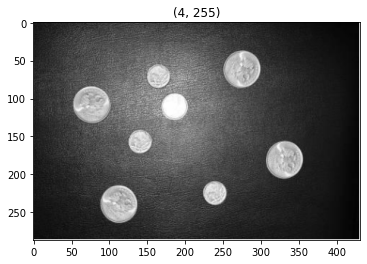

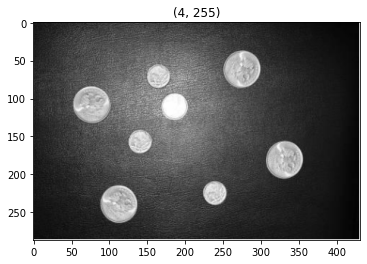

In [2]:
image_stock = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
pyplot_image_show(image_stock)
image_denoised =  rank.median(image_stock, disk(2))
pyplot_image_show(image_stock)

# Найдем морфологический градиент

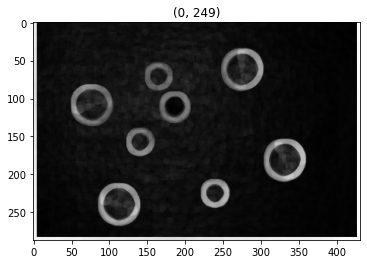

In [3]:
kernel_size = 8
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
morph_gradient = cv2.morphologyEx(image_denoised,cv2.MORPH_GRADIENT,kernel)
pyplot_image_show(morph_gradient)

# Найдем маркеры!

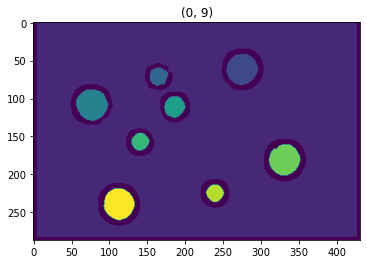

In [24]:
threshold = np.max(morph_gradient)//3
markers_prep = morph_gradient < threshold
markers = ndi.label(markers_prep)[0]
pyplot_image_show(markers,cmap='viridis')


# Запустим Watershed

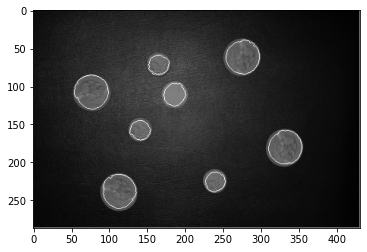

In [5]:
labels = watershed(image_stock, markers, watershed_line=True)
#pyplot_image_show(labels,cmap='viridis')
contours = labels==0
concatenate_images(image_stock,contours,0.5)

# Выполнено первое задание - выделены контуры монеток
# Следующее - считаем общее количество монет, и кол-во маленьких, больших
# Найдем количество пикселей в связных компонентах.

In [6]:
res = []
for i in range(2,labels.max()+1):
    res.append(np.count_nonzero(markers[markers==i]))
res = np.array(res)
res

array([1312,  448, 1322,  593,  412, 1299,  403, 1305])

# Заметим, что большие и маленькие монетки значительно отличаются по размеру. Возьмем K-means classifier.

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=0).fit(res.reshape(-1,1))

In [8]:
labels = np.copy(kmeans.labels_)
dict_names = {1:"small", 0:"large"}
dict_values = {1:0, 0:0}
if (kmeans.cluster_centers_[0][0] < kmeans.cluster_centers_[1][0]):
    dict1 = {0:"small", 1:"large"}

In [10]:
for i in dict_names.keys():
    dict_values[i] = np.count_nonzero([labels == i])

In [21]:
summa = 0
for i in dict_names.keys():
    print("The amount of {size} coins is {value}".format(size = dict_names[i],value = dict_values[i]))
    summa += dict_values[i]

The amount of small coins is 4
The amount of large coins is 4


In [23]:
"Total amount of coins is {value}".format(value=summa)

'Total amount of coins is 8'